In [ ]:
#import
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

In [ ]:

# define config
SEED = 42
EMBEDDING_VECTOR_LENGTH = 32
MAX_NUMBER_OF_PLAYS = 275
NUMBER_OF_CLASSES = 6
LSTM_SIZE = 100
EPOCHS = 1000
BATCH_SIZE = 64

# fix random seed for reproducibility
tf.random.set_seed(SEED)

In [ ]:
#read and format labels
Y = pd.read_csv('Cluster_Helios_2.txt', delimiter='\t', names=["Y", "X", "c", "Identity Score"])[["Y", "X"]]
Y = Y.sort_values('X')
Y = Y.set_index('X')

In [ ]:
#read and formmat data
X = pd.read_csv('Sequences_Helios.txt', lineterminator = '>', delimiter=',', header=None)
X.columns = [*X.columns[:-1], 'Test']
X = X.drop('Test', axis=1)
new = X[0].str.split('\n', n = 1, expand = True)
X["X"]= '>' + new[0]
X[0]= new[1]
X = X.sort_values('X')
X = X.set_index('X')

In [ ]:
#merge data and labels into single dataset for spliting
data = pd.merge(X, Y, left_index=True, right_index=True)

In [ ]:
#splits dataset into train and test, than returns it to the X and Y formmat *could be donne better0
train, test = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)

Y_train = train.pop('Y').to_numpy()
X_train = train.to_numpy()

Y_test = test.pop('Y').to_numpy()
X_test = test.to_numpy()

#change labels to one hot vector type
n_values = np.max(Y.max()[0]) + 1
Y_test = np.eye(n_values)[Y_test]
Y_train = np.eye(n_values)[Y_train]

#converts data to np array
Y_train = np.asarray(Y_train).astype('int')
X_train = np.asarray(X_train).astype('float32')
Y_test = np.asarray(Y_test).astype('int')
X_test = np.asarray(X_test).astype('float32')

#replaces nan values with zeroes
#X_train = np.nan_to_num(X_train)
#X_test = np.nan_to_num(X_test)

In [ ]:
#checks if everythin has right shape
print('X_train shape', X_train.shape)
print('X_test  shape', X_test.shape)
print('Y_train shape', Y_train.shape)
print('Y_test  shape', Y_test.shape)

X_train shape (304, 149)
X_test  shape (76, 149)
Y_train shape (304, 6)
Y_test  shape (76, 6)


In [ ]:


# create the model
model = Sequential()
model.add(Embedding(MAX_NUMBER_OF_PLAYS, EMBEDDING_VECTOR_LENGTH, input_length=X_train.shape[1], mask_zero=True))
model.add(LSTM(LSTM_SIZE))
model.add(Dense(NUMBER_OF_CLASSES, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=EPOCHS, batch_size=BATCH_SIZE)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 149, 32)           8800      
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense (Dense)               (None, 6)                 606       
                                                                 
Total params: 62,606
Trainable params: 62,606
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
5/5 [==============================] - 7s 596ms/step - loss: 0.6885 - accuracy: 0.1974 - val_loss: 0.6783 - val_accuracy: 0.3158
Epoch 2/1000
5/5 [==============================] - 1s 241ms/step - loss: 0.6681 - accuracy: 0.4145 - val_loss: 0.6406 - val_accuracy: 0.3421
Epoch 3/1000
5/5 [=========

In [ ]:
# Test the model after training
test_results = model.evaluate(X_test, Y_test, verbose=False)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {100*test_results[1]}%')


Test results - Loss: 0.41677260398864746 - Accuracy: 84.21052694320679%


In [ ]:
probs = model.predict(X_test)
for prob in probs:
  for j in range(6):
    if j == prob.argmax():
      prob[j] = 1
    else:
      prob[j] = 0
myDict = classification_report(Y_test, probs)
print(myDict)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.79      0.92      0.85        12
           2       0.56      0.90      0.69        10
           3       1.00      1.00      1.00        19
           4       0.94      1.00      0.97        16
           5       0.90      0.47      0.62        19

   micro avg       0.84      0.84      0.84        76
   macro avg       0.70      0.72      0.69        76
weighted avg       0.87      0.84      0.83        76
 samples avg       0.84      0.84      0.84        76



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
a = multilabel_confusion_matrix(Y_test, probs)
print(a)

[[[76  0]
  [ 0  0]]

 [[61  3]
  [ 1 11]]

 [[59  7]
  [ 1  9]]

 [[57  0]
  [ 0 19]]

 [[59  1]
  [ 0 16]]

 [[56  1]
  [10  9]]]


In [ ]:
a = multilabel_confusion_matrix(Y_test, probs)
a[5]

array([[56,  1],
       [10,  9]])

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.79      0.92      0.85        12
           2       0.56      0.90      0.69        10
           3       1.00      1.00      1.00        19
           4       0.94      1.00      0.97        16
           5       0.90      0.47      0.62        19

   micro avg       0.84      0.84      0.84        76
   macro avg       0.70      0.72      0.69        76
weighted avg       0.87      0.84      0.83        76
 samples avg       0.84      0.84      0.84        76



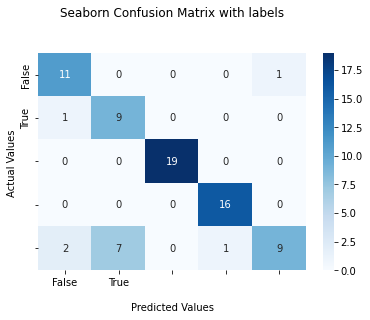

In [ ]:
#Predict probabilities
Y_probs = model.predict(X_test)

#Classify based on probabilities
Y_preds = Y_probs.copy()
for pred in Y_preds:
  for j in range(NUMBER_OF_CLASSES):
    if j == pred.argmax():
      pred[j] = 1
    else:
      pred[j] = 0

#Calculate precision, recall and f1
cr = classification_report(Y_test, Y_preds)
print(cr)

#Calculate confusion matrix
cm = confusion_matrix(Y_test.argmax(axis=1), Y_preds.argmax(axis=1))

#plot confusion matrix
ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['1','2','3','4','5','6', '7', '8','9','10'])
ax.yaxis.set_ticklabels(['1','2','3','4','5','6', '7', '8','9','10'])

## Display the visualization of the Confusion Matrix.
plt.show()

######################   ITERAÇÃO 0   ######################
SEQUÊNCIAS DE  0 A 29
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.40      0.17      0.24        12
           2       0.42      0.50      0.45        10
           3       0.71      0.89      0.79        19
           4       0.94      1.00      0.97        16
           5       0.67      0.63      0.65        19

   micro avg       0.68      0.68      0.68        76
   macro avg       0.52      0.53      0.52        76
weighted avg       0.66      0.68      0.66        76
 samples avg       0.68      0.68      0.68        76



Valor médio da Diagonal
10.4


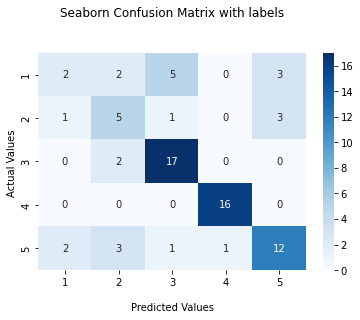







######################   ITERAÇÃO 1   ######################
SEQUÊNCIAS DE  0 A 59
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.60      0.50      0.55        12
           2       0.47      0.70      0.56        10
           3       0.85      0.89      0.87        19
           4       0.94      1.00      0.97        16
           5       0.71      0.53      0.61        19

   micro avg       0.74      0.74      0.74        76
   macro avg       0.60      0.60      0.59        76
weighted avg       0.75      0.74      0.73        76
 samples avg       0.74      0.74      0.74        76



Valor médio da Diagonal
11.2


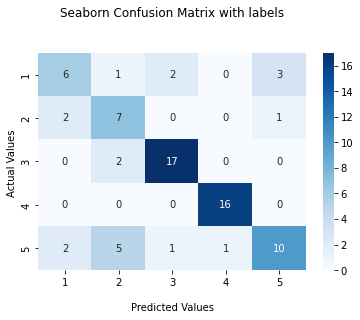







######################   ITERAÇÃO 2   ######################
SEQUÊNCIAS DE  0 A 89
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.69      0.75      0.72        12
           2       0.62      0.80      0.70        10
           3       1.00      1.00      1.00        19
           4       0.94      1.00      0.97        16
           5       0.79      0.58      0.67        19

   micro avg       0.83      0.83      0.83        76
   macro avg       0.67      0.69      0.68        76
weighted avg       0.83      0.83      0.83        76
 samples avg       0.83      0.83      0.83        76



Valor médio da Diagonal
12.6


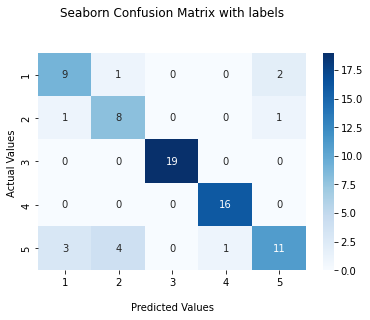







######################   ITERAÇÃO 3   ######################
SEQUÊNCIAS DE  0 A 119
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.77      0.83      0.80        12
           2       0.50      0.90      0.64        10
           3       1.00      1.00      1.00        19
           4       0.94      1.00      0.97        16
           5       1.00      0.47      0.64        19

   micro avg       0.83      0.83      0.83        76
   macro avg       0.70      0.70      0.68        76
weighted avg       0.89      0.83      0.83        76
 samples avg       0.83      0.83      0.83        76



Valor médio da Diagonal
12.6


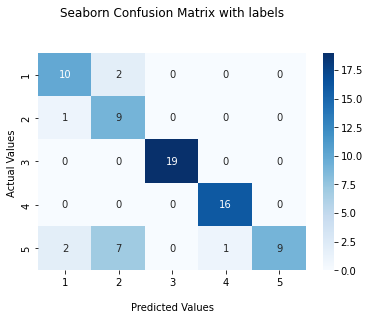







######################   ITERAÇÃO 4   ######################
SEQUÊNCIAS DE  0 A 149
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.79      0.92      0.85        12
           2       0.56      0.90      0.69        10
           3       1.00      1.00      1.00        19
           4       0.94      1.00      0.97        16
           5       0.90      0.47      0.62        19

   micro avg       0.84      0.84      0.84        76
   macro avg       0.70      0.72      0.69        76
weighted avg       0.87      0.84      0.83        76
 samples avg       0.84      0.84      0.84        76



Valor médio da Diagonal
12.8


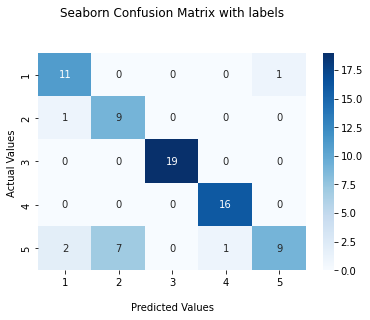

In [ ]:
X_p = np.empty((5, X_test.shape[0], X_train.shape[1]))
for i in range(1, 6):
  for j in range(0, X_test.shape[0]):
    X_p[i-1][j] = np.pad( X_test[j, 0:int(i*X_train.shape[1]/5)], (0, max(X_train.shape[1] - int(i*X_train.shape[1]/5),0) ))

for i in range(1,6):

  print("######################   ITERAÇÃO", i-1, "  ######################")
  print("SEQUÊNCIAS DE ", 0, "A", int(i*X_train.shape[1]/5))

  #Predict probabilities
  Y_probs = model.predict(X_p[i-1])

  #Classify based on probabilities
  Y_preds = Y_probs.copy()
  for pred in Y_preds:
    for j in range(NUMBER_OF_CLASSES):
      if j == pred.argmax():
        pred[j] = 1
      else:
        pred[j] = 0

  #Calculate precision, recall and f1
  cr = classification_report(Y_test, Y_preds, zero_division=0)
  print("Classification Report")
  print(cr)
  print('')
  print('')
  
  #Calculate confusion matrix
  cm = confusion_matrix(Y_test.argmax(axis=1), Y_preds.argmax(axis=1))
  
  val = 0
  for linha in range(cm.shape[0]):
    val = val + cm[linha, linha]
  
  print("Valor médio da Diagonal")
  print(val/cm.shape[0])
  
  #plot confusion matrix
  ax = sns.heatmap(cm, annot=True, cmap='Blues')

  ax.set_title('Seaborn Confusion Matrix with labels\n\n');
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(['1','2','3','4','5'])
  ax.yaxis.set_ticklabels(['1','2','3','4','5'])

  ## Display the visualization of the Confusion Matrix.
  plt.show()

  print('')
  print('') 
  print('')
  print('')
  print('')
  print('')